In [2]:
import pandas as pd
import seaborn as sns
import pickle
filename = '/data2/Projects/eeg_fmri_natview/derivatives/sub-01/ses-01/eeg/sub-01_ses-01_task-monkey1_run-01_desc-RawBk_eeg.pkl'
with open(filename, 'rb') as file:
    data = pickle.load(file)


In [5]:
import matplotlib.pyplot as plt
import pandas as pd
def plot_heatmap(cap:pd.DataFrame, title:str):
    # Define the desired anatomical order
    desired_order = [
        'frontopolar', 'frontal', 'anterior-frontal', 'fronto-temporal', 
        'temporal', 'fronto-central', 'central', 'centro-parietal', 'parietal', 
        'temporo-parietal', 'parieto-occipital', 'occipital'
    ]

    heatmap_data = cap.pivot_table(
        index='ch_name',
        columns='frequency_Hz',
        values='pearson_r',
        aggfunc='mean'
    )

    # Sort electrodes by anatomy
    sorted_data = cap[['ch_name', 'anatomy']].drop_duplicates().set_index('ch_name')
    heatmap_data = heatmap_data.loc[sorted_data.sort_values('anatomy').index]

    # Sort the electrodes by the desired anatomical order
    sorted_anatomy = sorted_data.loc[
        sorted_data['anatomy'].astype('category').cat.set_categories(desired_order, ordered=True).sort_values().index
    ]

    # Reorder the heatmap data based on the sorted anatomy
    sorted_heatmap_data = heatmap_data.loc[sorted_anatomy.index]

    # Plot the heatmap with sorted anatomical groups
    figure = plt.figure(figsize=(15, 13))
    ax = sns.heatmap(
        sorted_heatmap_data,
        cmap='bwr',
        cbar_kws={'label': 'Pearson Correlation'},
        annot=False,
        linewidths=0.5,
        #linecolor='black',
        #vmin = -1,
        #vmax = 1
    )

    # Add separators and labels for sorted anatomical groups
    current_position = 0
    for anatomy in desired_order:
        indices = sorted_anatomy.groupby('anatomy').groups[anatomy]
        next_position = current_position + len(indices)
        # Add a horizontal line to separate anatomical groups
        ax.hlines(y=next_position, xmin=-2, xmax=len(sorted_heatmap_data.columns), colors='black', linewidth=2)
        # Add a single anatomical region label
        ax.text(
            x=-1.5, 
            y=(current_position + next_position) / 2, 
            s=anatomy.capitalize(), 
            fontsize=10, 
            color='black', 
            va='center', 
            ha='right', 
            rotation=0, 
            fontweight='bold'
        )
        current_position = next_position

    # Adjust labels and title
    ax.set_title(f'Correlation (yhat,ytest) {title}', fontsize=16)
    ax.set_xlabel('Frequency (Hz)', fontsize=14)
    ax.set_ylabel('')
    #ax.set_yticklabels('')
    plt.tight_layout()
    #plt.show()
    return ax, figure

In [6]:
import matplotlib.backends.backend_pdf
pdf = matplotlib.backends.backend_pdf.PdfPages("individual_eval_custom_env_adjusted.pdf")
caps = [c for c in range(1,9)]
for subject in range(23):
    print(subject)
    try:
        df = pd.read_csv(f"/home/slouviot/01_projects/eeg_brain_state_prediction/data/sub-{subject:02}_task-checker_desc-CustomEnvBk_predictions.csv")
    except Exception as e:
        print(e)
        continue
    for cap in caps:
        cap_df = df.loc[df['ts_CAPS'] == f'CAP{cap}', ['pearson_r', 'frequency_Hz', 'electrode']]
        anatomy = data['labels']['channels_info']['anatomy']
        names = data['labels']['channels_info']['channel_name']
        cap_df['anatomy'] = [anatomy[idx] for idx in cap_df['electrode']]
        cap_df['ch_name'] = [names[idx] for idx in cap_df['electrode']]
        ax, figure = plot_heatmap(cap_df, f"Subject {subject:02} CAP{cap}")
        pdf.savefig(figure)
        plt.close(figure)

pdf.close()

0
[Errno 2] No such file or directory: '/home/slouviot/01_projects/eeg_brain_state_prediction/data/sub-00_task-checker_desc-CustomEnvBk_predictions.csv'
1
2
3
[Errno 2] No such file or directory: '/home/slouviot/01_projects/eeg_brain_state_prediction/data/sub-03_task-checker_desc-CustomEnvBk_predictions.csv'
4
[Errno 2] No such file or directory: '/home/slouviot/01_projects/eeg_brain_state_prediction/data/sub-04_task-checker_desc-CustomEnvBk_predictions.csv'
5
6
7
8
9
10
[Errno 2] No such file or directory: '/home/slouviot/01_projects/eeg_brain_state_prediction/data/sub-10_task-checker_desc-CustomEnvBk_predictions.csv'
11
12
13
14
15
16
17
18
19
[Errno 2] No such file or directory: '/home/slouviot/01_projects/eeg_brain_state_prediction/data/sub-19_task-checker_desc-CustomEnvBk_predictions.csv'
20
21
22


# Average across subject (y = electrodes, x = frequency)

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy
def plot_heatmap(
        cap:pd.DataFrame, 
        title:str, 
        ax: matplotlib.axes, 
        colorbar: bool = True,
        plot_anat: bool = True,
        x_labels: bool = True,
        metrics: str | function = 'mean',
                 ):
    # Define the desired anatomical order
    desired_order = [
        'frontopolar', 'frontal', 'anterior-frontal', 'fronto-temporal', 
        'temporal', 'fronto-central', 'central', 'centro-parietal', 'parietal', 
        'temporo-parietal', 'parieto-occipital', 'occipital'
    ]

    heatmap_data = cap.pivot_table(
        index='ch_name',
        columns='frequency_Hz',
        values='pearson_r',
        aggfunc=metrics,
    )

    # Sort electrodes by anatomy
    sorted_data = cap[['ch_name', 'anatomy']].drop_duplicates().set_index('ch_name')
    heatmap_data = heatmap_data.loc[sorted_data.sort_values('anatomy').index]

    # Sort the electrodes by the desired anatomical order
    sorted_anatomy = sorted_data.loc[
        sorted_data['anatomy'].astype('category').cat.set_categories(desired_order, ordered=True).sort_values().index
    ]

    # Reorder the heatmap data based on the sorted anatomy
    sorted_heatmap_data = heatmap_data.loc[sorted_anatomy.index]

    # Plot the heatmap with sorted anatomical groups
    sns.heatmap(
        sorted_heatmap_data,
        cmap='bwr',
        cbar = colorbar,
        #cbar_kws={'label': 'Pearson Correlation'},
        annot=False,
        linewidths=0.5,
        ax = ax,
        linecolor=None,
        #linecolor='black',
        #vmin = -1,
        #vmax = 1,
    )

    # Add separators and labels for sorted anatomical groups
    current_position = 0
    for anatomy in desired_order:
        indices = sorted_anatomy.groupby('anatomy').groups[anatomy]
        next_position = current_position + len(indices)
        # Add a horizontal line to separate anatomical groups
        ax.hlines(y=next_position, xmin=-2, xmax=len(sorted_heatmap_data.columns), colors='black', linewidth=2)
        # Add a single anatomical region label
        if plot_anat:
            ax.text(
                x=-1.5, 
                y=(current_position + next_position) / 2, 
                s=anatomy.capitalize(), 
                #ontsize=10, 
                color='black', 
                va='center', 
                ha='right', 
                rotation=0, 
                fontweight='bold'
            )
        current_position = next_position
    else:
        ax.set_yticklabels('')
    
    if not x_labels:
        ax.set_xlabel('')
        ax.set_xticks([])
        

    # Adjust labels and title
    ax.set_title(f'{title}')
    ax.set_ylabel('')
    ax.set_yticks([])
    #plt.show()
    return ax

In [1]:
from bids_explorer.architecture import BidsArchitecture
from pathlib import Path
paramters = {
    "root": Path("/data2/Projects/eeg_fmri_natview/derivatives"),
    "datatype": "multimodal",
    "suffix": "multimodal",
    "description": "CustomEnvBk8",
    "run": "01",
    "task": "checker",
    "extension": ".pkl",
}
architecture = BidsArchitecture(**paramters)

In [22]:
import pandas as pd
import seaborn as sns
import pickle

task = 'checker'
filename = '/data2/Projects/eeg_fmri_natview/derivatives/sub-01/ses-01/eeg/sub-01_ses-01_task-monkey1_run-01_desc-RawBk_eeg.pkl'
with open(filename, 'rb') as file:
    data = pickle.load(file)
caps = [c for c in range(1,9)]
r = []
dfs = []
anatomy = data['labels']['channels_info']['anatomy']
names = data['labels']['channels_info']['channel_name']
for subject in range(1,23):
    print(subject)
    try:
        df = pd.read_csv(f"/home/slouviot/01_projects/eeg_brain_state_prediction/data/sub-{subject:02}_task-{task}_desc-CustomEnvBk_predictions.csv")
        df['anatomy'] = [anatomy[idx] for idx in df['electrode']]
        df['ch_name'] = [names[idx] for idx in df['electrode']]
        df.drop(columns='Unnamed: 0', inplace = True)
        dfs.append(df)
    except Exception as e:
        print(e)
        continue
df = pd.concat(dfs, axis = 0)
df_freq_cap = df.groupby(['ts_CAPS']).mean('pearson_r').reset_index()['ts_CAPS']
df['subject'] = df['subject'].astype('category')
df.to_csv(f'/home/slouviot/01_projects/eeg_brain_state_prediction/data/custom_bands_all_{task}.csv')


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
[Errno 2] No such file or directory: '/home/slouviot/01_projects/eeg_brain_state_prediction/data/sub-19_task-checker_desc-CustomEnvBk_predictions.csv'
20
21
22


/tmp/ipykernel_384242/677800539.py:25: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(dfs, axis = 0)


In [3]:
selection_without_subject = df.groupby(['ts_CAPS', 'frequency_Hz', 'electrode']).mean('pearson_r').reset_index()
#features = selection[selection['ts_CAPS'] == 'CAP1'].sort_values('pearson_r', ascending=False)[['electrode','frequency_Hz']].values[:i]
#electrodes, frequencies = features.T


In [6]:
selection_without_subject

ts_CAPS  frequency_Hz  electrode  pearson_r
0        CAP1             1          0   0.102275
1        CAP1             1          1   0.107567
2        CAP1             1          2   0.101265
3        CAP1             1          3   0.093164
4        CAP1             1          4   0.093780
...       ...           ...        ...        ...
19027    CAP8            39         56   0.219477
19028    CAP8            39         57   0.219582
19029    CAP8            39         58   0.219517
19030    CAP8            39         59   0.217915
19031    CAP8            39         60   0.218917

[19032 rows x 4 columns]

In [22]:
def plot_elec_pearson(cap, ax):
    sns.stripplot(
        data=df.loc[(df['ts_CAPS'] == cap) & (df['frequency_Hz'] == 1)], 
        x="pearson_r", 
        y="electrode",
        hue = 'subject',
        orient='h',
        alpha=.7, 
        s = 3,
        zorder=1,
        legend=True,
        ax = ax,
    )
    sns.pointplot(
        data=selection_without_subject.loc[(selection_without_subject['ts_CAPS'] == cap) & (selection_without_subject['frequency_Hz'] == 1)],
        x="pearson_r", 
        y="electrode", 
        orient='h',
        linestyle="none", 
        errorbar=None,
        marker="|", 
        color = 'black',
        n_boot=5,
        markersize=5, 
        markeredgewidth=2,
        ax = ax,
    )
    handles, labels = ax.get_legend_handles_labels()

    # Create a new list of handles with alpha set to 1
    new_handles = []
    for handle in handles:
        handle.set_alpha(1)
        new_handles.append(handle)

    # Update the legend with the new handles
    ax.legend(title = 'Subjects', handles=new_handles, labels=labels)
    sns.move_legend(
        ax, loc="upper right", ncol=1, frameon=True, handletextpad=0,
        bbox_to_anchor = (1,1)
    )
    plt.title(cap)

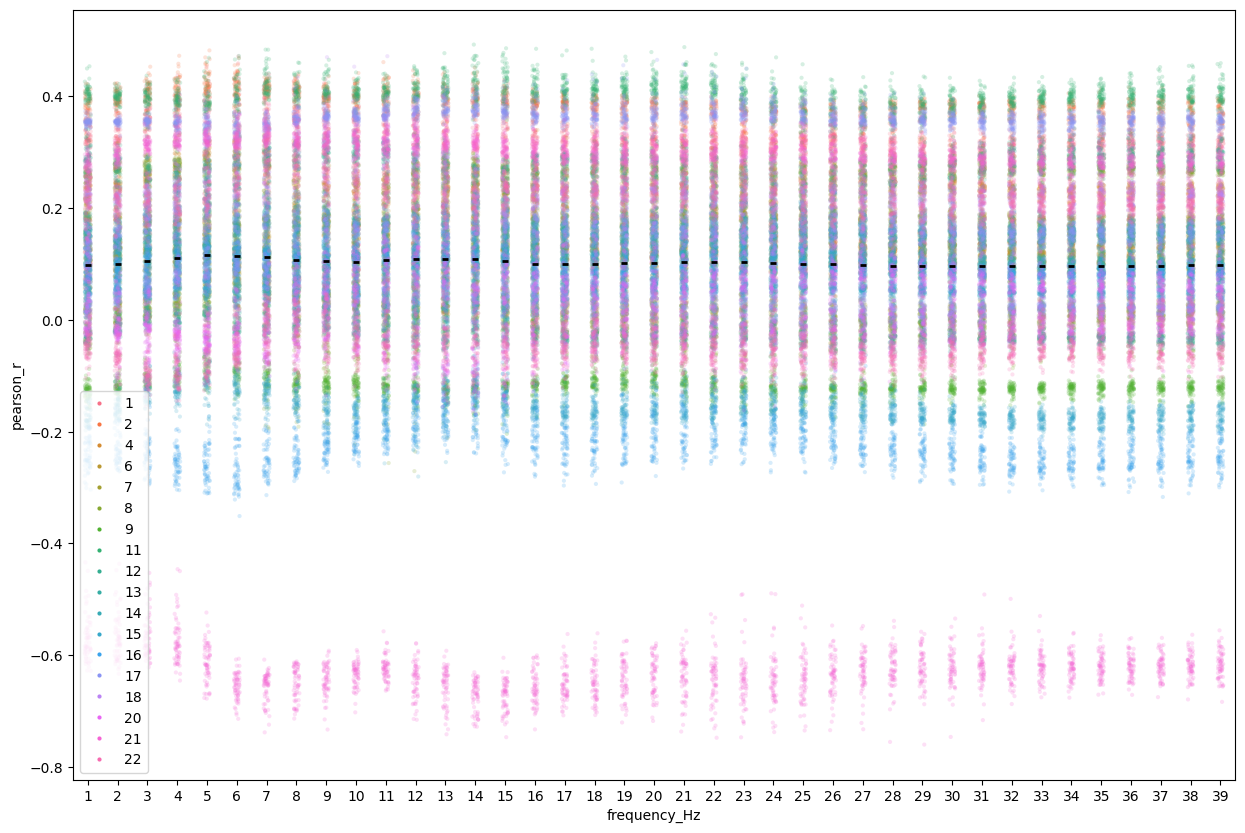

In [35]:

fig, ax = plt.subplots(figsize = (15,10))
sns.stripplot(
    data=df.loc[df['ts_CAPS'] == 'CAP1'], 
    x="frequency_Hz", 
    y="pearson_r",
    hue = 'subject',
    orient='v',
    alpha=.2, 
    s = 3,
    zorder=1,
    legend=True,
)
average_electrodes = selection_without_subject.groupby(['ts_CAPS', 'frequency_Hz']).mean('pearson_r').reset_index()
sns.pointplot(
    data=selection_without_subject.loc[selection_without_subject['ts_CAPS'] == 'CAP1'],
    x="frequency_Hz", 
    y="pearson_r", 
    orient='v',
    linestyle="none", 
    errorbar=None,
    marker="_", 
    color = 'black',
    n_boot=5,
    markersize=5, 
    markeredgewidth=2,
)
#plt.ylim(0.2,0.3)
# Get the legend handles and labels
handles, labels = ax.get_legend_handles_labels()

# Create a new list of handles with alpha set to 1
new_handles = []
for handle in handles:
    handle.set_alpha(1)
    new_handles.append(handle)

# Update the legend with the new handles
ax.legend(handles=new_handles, labels=labels)

In [40]:
df.loc[df['pearson_r'] < -0.3,'subject'].unique()

[1, 9, 15, 16, 21]
Categories (18, int64): [1, 2, 4, 6, ..., 18, 20, 21, 22]

<Axes: xlabel='pearson_r', ylabel='frequency_Hz'>

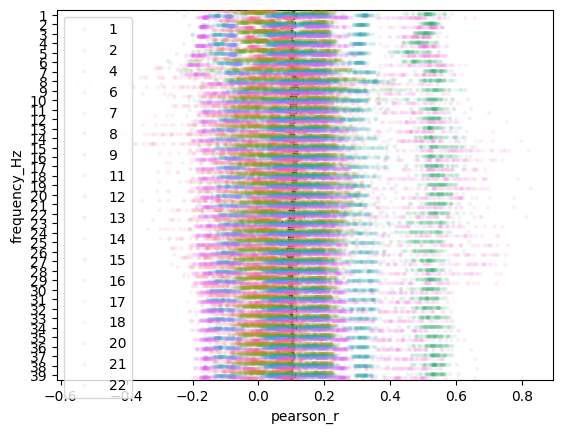

In [17]:
import seaborn as sns
sns.stripplot(data = df[df['ts_CAPS'] == 'CAP3'],
        x = 'pearson_r', 
        y = 'frequency_Hz', 
        hue = 'subject', 
        orient='h',
        alpha = 0.1,
        s = 3,
        dodge = True,
        )
sns.boxplot(data = selection_without_subject.loc[selection_without_subject['ts_CAPS'] == 'CAP3'], 
        x = 'pearson_r',
        y = 'frequency_Hz',
        fill = False,
        color = 'black', 
        orient='h',
        whis=(0,100),
        linewidth = 1,
        )

In [2]:
def plot_boxplot_per_cap(n, ax, fig):
    cap = df_freq_cap.iloc[n]
    selection = df[(df['ts_CAPS'] == cap)]
    plt.cla()
    sns.boxplot(data = selection, 
            x = 'pearson_r',
            y = 'frequency_Hz',
            fill = False,
            color = 'black', 
            orient='h',
            whis=(0,100),
            linewidth = 1,
            ax = ax,
            )
    sns.stripplot(data = selection,
            x = 'pearson_r', 
            y = 'frequency_Hz', 
            hue = 'subject', 
            orient='h',
            alpha = 0.2,
            s = 4,
            dodge = True,
            ax = ax,
            )
    sns.move_legend(
        ax, loc="upper right", ncol=1, frameon=True, handletextpad=0,
        bbox_to_anchor = (1,1)
    )
    # Get the legend handles and labels
    handles, labels = ax.get_legend_handles_labels()

    # Create a new list of handles with alpha set to 1
    new_handles = []
    for handle in handles:
        handle.set_alpha(1)
        new_handles.append(handle)

    # Update the legend with the new handles
    ax.legend(handles=new_handles, labels=labels)
    plt.xlim(-1,1)
    plt.title(f'{cap}')
    plt.axvline(0, color = 'grey', linewidth = 1, linestyle = '--')
    return fig, ax

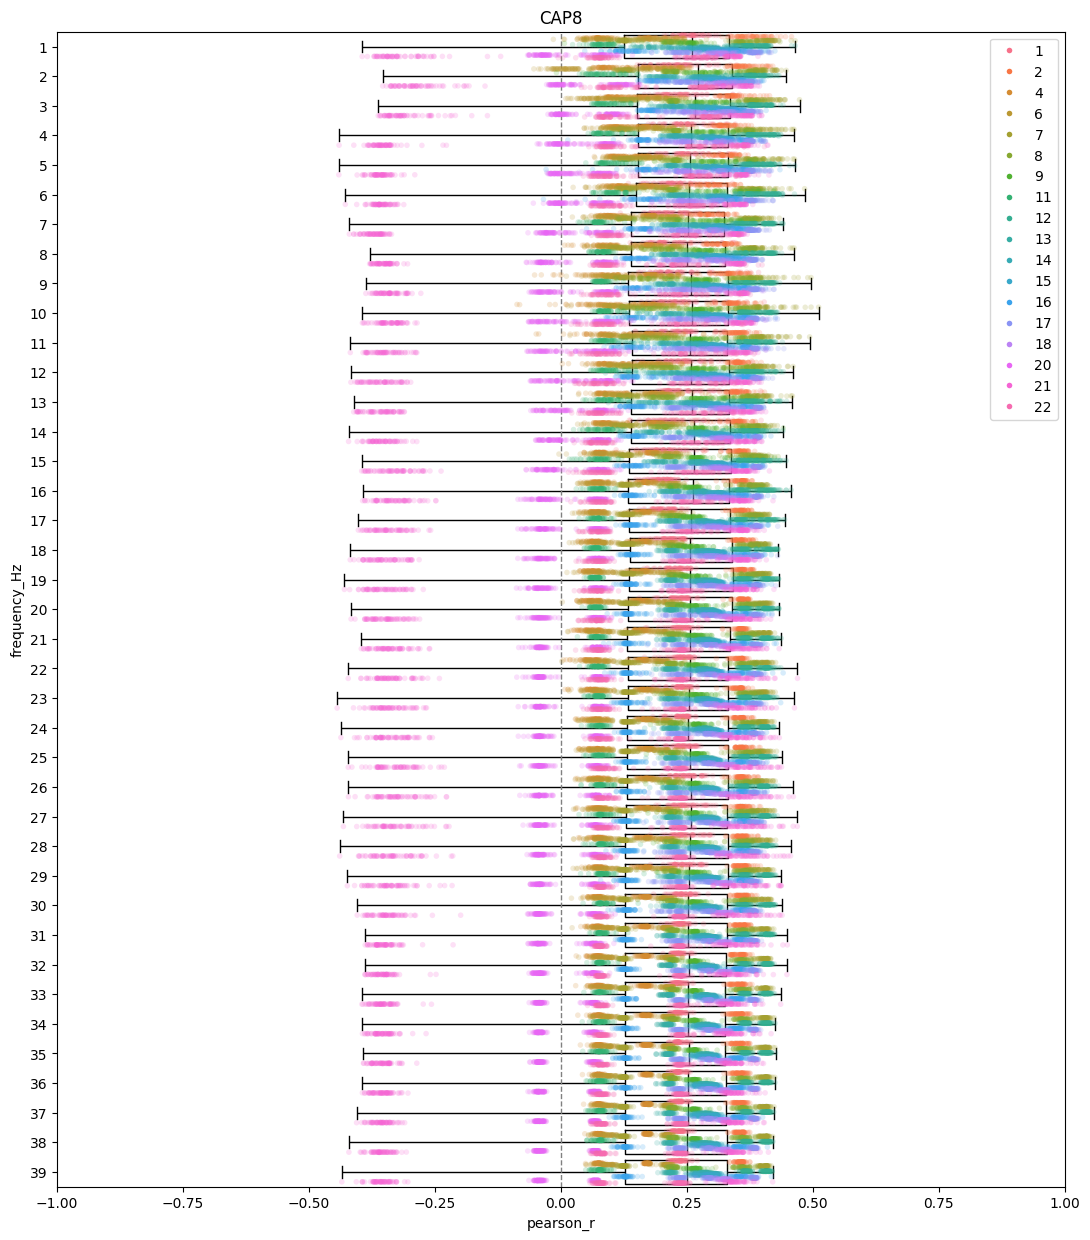

In [3]:
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
pdf = PdfPages(f'boxplot_custom_band_per_cap_{task}.pdf')
fig, ax = plt.subplots(figsize = (13,15))
for n in range(len(df_freq_cap)):
    fig, ax = plot_boxplot_per_cap(n, ax, fig)
    pdf.savefig(fig)
pdf.close()
    

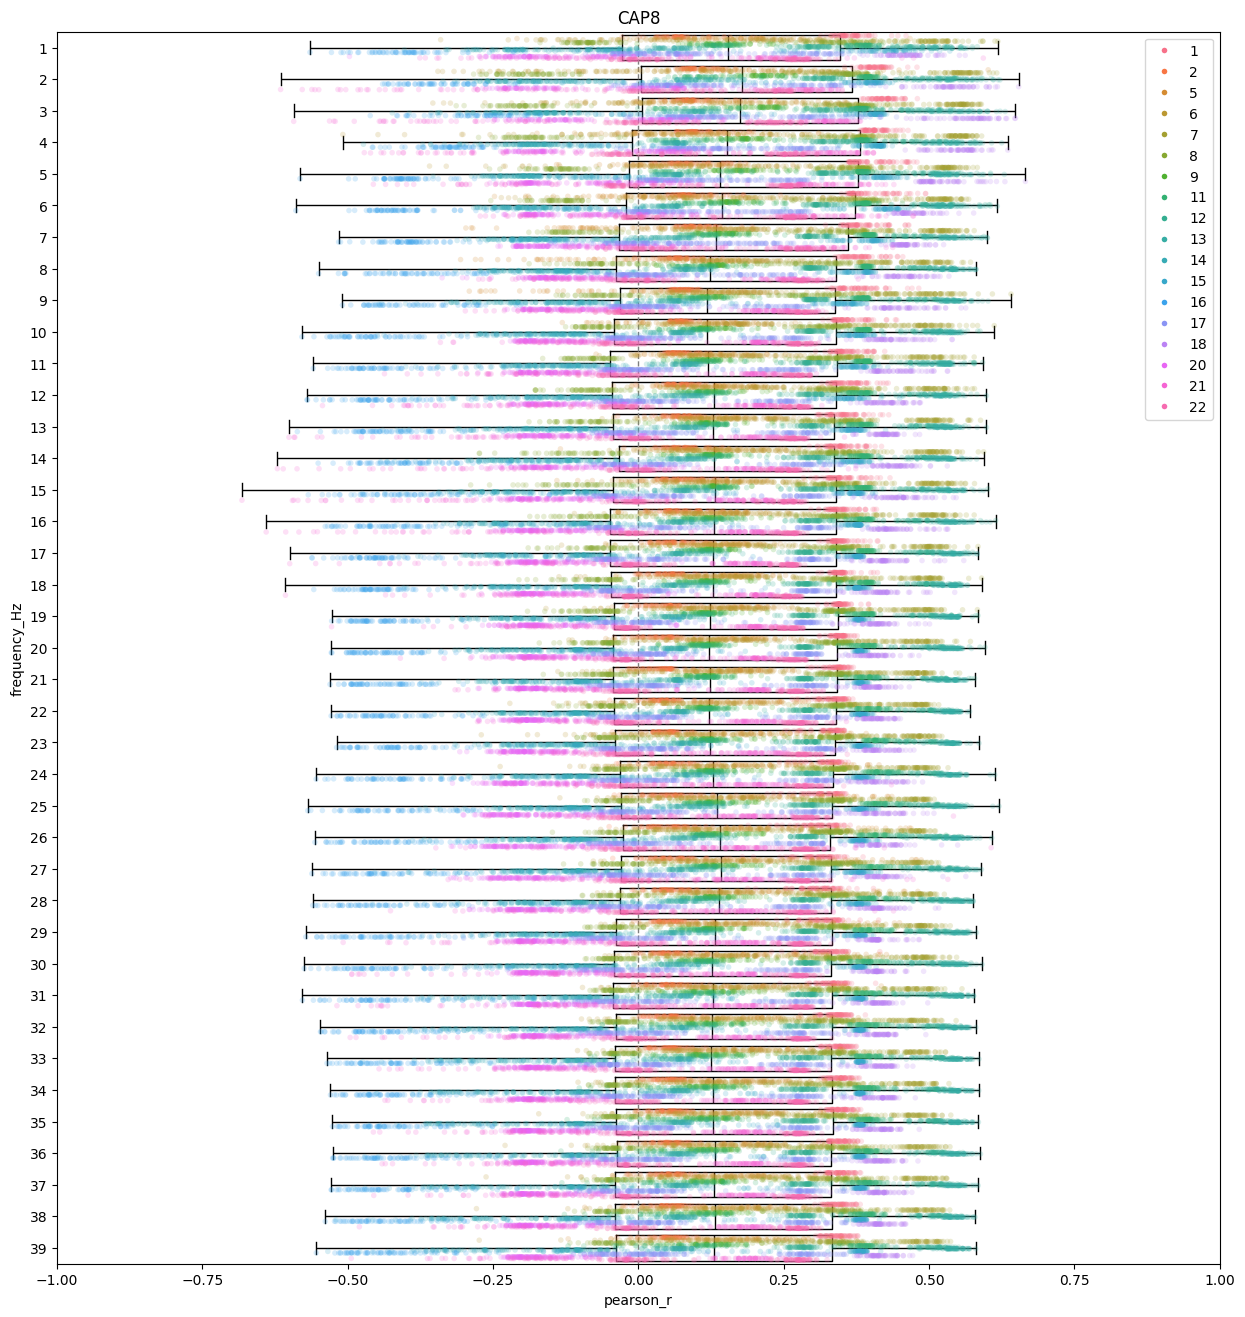

/tmp/ipykernel_968968/3259690596.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  anatomy_to_channels = selection.groupby('anatomy')['ch_name'].unique().reindex(desired_order)


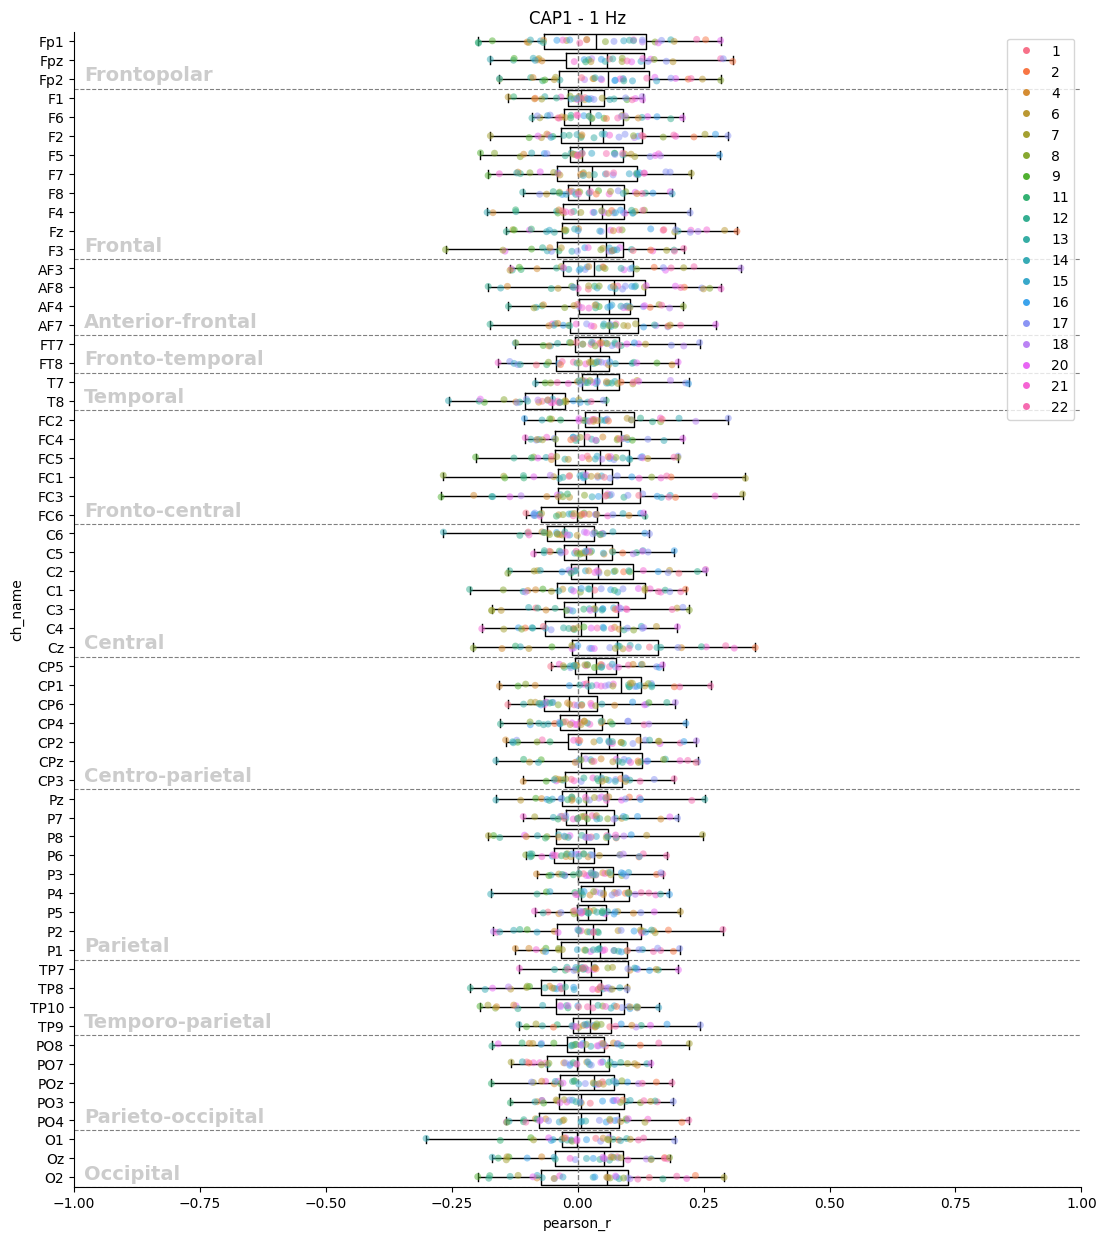

In [26]:
import pandas as pd
import seaborn as sns
from pathlib import Path
import matplotlib.pyplot as plt
df = pd.read_csv(Path().cwd().parents[0]/Path("data","sub-all_task-rest_desc-CustomEnvBk_predictions.csv"))
fig, ax = plt.subplots(figsize = (13,15))
cap = 'CAP1'
frequency = 1
selection = df[(df['ts_CAPS'] == cap) & (df['frequency_Hz'] == frequency)]
desired_order = [
    'frontopolar', 'frontal', 'anterior-frontal', 'fronto-temporal', 
    'temporal', 'fronto-central', 'central', 'centro-parietal', 'parietal', 
    'temporo-parietal', 'parieto-occipital', 'occipital'
]
selection = selection[selection['anatomy'].isin(desired_order)]
selection['anatomy'] = pd.Categorical(selection['anatomy'], categories=desired_order, ordered=True)
selection = selection.sort_values('anatomy')
anatomy_to_channels = selection.groupby('anatomy')['ch_name'].unique().reindex(desired_order)
ordered_channels = [ch for channels in anatomy_to_channels.dropna() for ch in channels]
selection['subject'] = selection['subject'].astype('category')

sns.boxplot(data = selection, 
        x = 'pearson_r',
        y = 'ch_name',
        fill = False,
        color = 'black', 
        orient='h',
        whis=(0,100),
        linewidth = 1,
        ax = ax,
        #order = ordered_channels,
        )
sns.stripplot(data = selection,
        x = 'pearson_r', 
        y = 'ch_name', 
        hue = 'subject', 
        orient='h',
        ax = ax,
        alpha = 0.5,
        #order = ordered_channels,
        )
ax.spines[['top','right']].set_visible(False)
# Add separators and labels for sorted anatomical groups
current_y = -0.5
for anatomy, channels in anatomy_to_channels.items():
    if pd.notna(channels).all():
        current_y += len(channels)

        # Add a single anatomical region label
        ax.text(
                x=-0.98, 
                y=current_y - 0.7,
                s=anatomy.capitalize(), 
                fontsize=14, 
                color='grey',
                va='center', 
                ha='left', 
                rotation=0, 
                fontweight='bold',
                alpha = 0.4,
        )
        ax.axhline(current_y, color='gray', linestyle='--', linewidth=0.8)

handles, labels = ax.get_legend_handles_labels()

# Create a new list of handles with alpha set to 1
new_handles = []
for handle in handles:
        handle.set_alpha(1)
        new_handles.append(handle)

# Update the legend with the new handles
ax.legend(handles=new_handles, labels=labels)
plt.gca().get_legend().set_loc('upper right')
plt.xlim(-1,1)
plt.title(f'{cap} - {frequency} Hz')
plt.axvline(0, color = 'grey', linewidth = 1, linestyle = '--')

/tmp/ipykernel_968968/2113078312.py:27: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  anatomy_to_channels = selection.groupby('anatomy')['ch_name'].unique().reindex(desired_order)


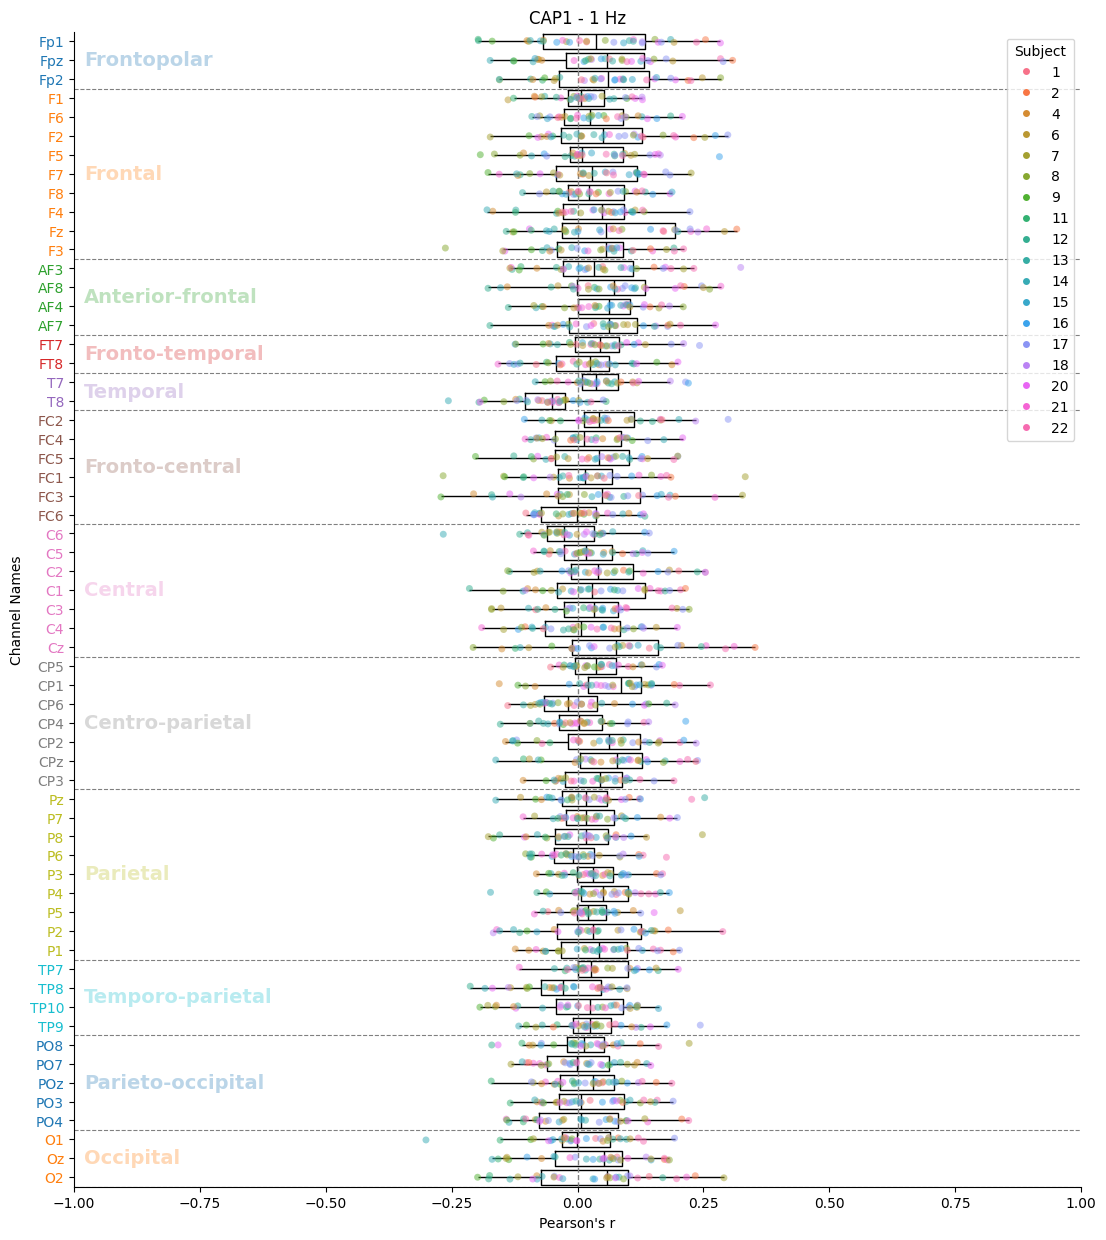

In [34]:
import pandas as pd
import seaborn as sns
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# Load the data
df = pd.read_csv(Path().cwd().parents[0] / Path("data", "sub-all_task-rest_desc-CustomEnvBk_predictions.csv"))

# Initialize figure
fig, ax = plt.subplots(figsize=(13, 15))

# Filter data
cap = 'CAP1'
frequency = 1
selection = df[(df['ts_CAPS'] == cap) & (df['frequency_Hz'] == frequency)]

# Define desired anatomical order and filter data
desired_order = [
    'frontopolar', 'frontal', 'anterior-frontal', 'fronto-temporal', 
    'temporal', 'fronto-central', 'central', 'centro-parietal', 'parietal', 
    'temporo-parietal', 'parieto-occipital', 'occipital'
]
selection = selection[selection['anatomy'].isin(desired_order)]
selection['anatomy'] = pd.Categorical(selection['anatomy'], categories=desired_order, ordered=True)
selection = selection.sort_values('anatomy')
anatomy_to_channels = selection.groupby('anatomy')['ch_name'].unique().reindex(desired_order)
ordered_channels = [ch for channels in anatomy_to_channels.dropna() for ch in channels]
selection['subject'] = selection['subject'].astype('category')

# Assign colors to anatomical groups
color_palette = sns.color_palette("tab10", len(desired_order))
anatomy_colors = dict(zip(desired_order, color_palette))

# Draw the boxplot
sns.boxplot(
    data=selection, 
    x='pearson_r',
    y='ch_name',
    color='black', 
    fill=False,
    orient='h',
    showfliers=False,
    linewidth=1,
    fliersize=0,
    capwidths=0,
    ax=ax,
)

# Draw the stripplot
sns.stripplot(
    data=selection,
    x='pearson_r', 
    y='ch_name', 
    hue='subject', 
    orient='h',
    ax=ax,
    alpha=0.5,
    dodge=False,
)

# Add separators and labels for anatomical groups
current_y = -0.5
for anatomy, channels in anatomy_to_channels.items():
    if pd.notna(channels).all():
        current_y += len(channels)

        # Add a single anatomical region label with color
        ax.text(
            x=-0.98, 
            y=current_y - len(channels) / 2,
            s=anatomy.capitalize(), 
            fontsize=14, 
            color=anatomy_colors[anatomy],
            va='center', 
            ha='left', 
            rotation=0, 
            alpha = 0.3,
            fontweight='bold',
        )
        ax.axhline(current_y, color='gray', linestyle='--', linewidth=0.8)

# Update ch_name labels with colors
for label in ax.get_yticklabels():
    channel_name = label.get_text()
    for anatomy, channels in anatomy_to_channels.items():
        if channel_name in channels:
            label.set_color(anatomy_colors[anatomy])
            break

# Customize legend
handles, labels = ax.get_legend_handles_labels()
# Create a new list of handles with alpha set to 1
new_handles = []
for handle in handles:
        handle.set_alpha(1)
        new_handles.append(handle)

ax.legend(handles=new_handles, loc='upper right', title='Subject')

# Finalize plot
ax.spines[['top', 'right']].set_visible(False)
plt.xlim(-1, 1)
plt.title(f'{cap} - {frequency} Hz')
plt.axvline(0, color='grey', linewidth=1, linestyle='--')
plt.ylabel('Channel Names')
plt.xlabel("Pearson's r")
plt.show()


In [6]:
ordered_channels

['Fp1',
 'Fpz',
 'Fp2',
 'F1',
 'F6',
 'F2',
 'F5',
 'F7',
 'F8',
 'F4',
 'Fz',
 'F3',
 'AF3',
 'AF8',
 'AF4',
 'AF7',
 'FT7',
 'FT8',
 'T7',
 'T8',
 'FC2',
 'FC4',
 'FC5',
 'FC1',
 'FC3',
 'FC6',
 'C6',
 'C5',
 'C2',
 'C1',
 'C3',
 'C4',
 'Cz',
 'CP5',
 'CP1',
 'CP6',
 'CP4',
 'CP2',
 'CPz',
 'CP3',
 'Pz',
 'P7',
 'P8',
 'P6',
 'P3',
 'P4',
 'P5',
 'P2',
 'P1',
 'TP7',
 'TP8',
 'TP10',
 'TP9',
 'PO8',
 'PO7',
 'POz',
 'PO3',
 'PO4',
 'O1',
 'Oz',
 'O2']

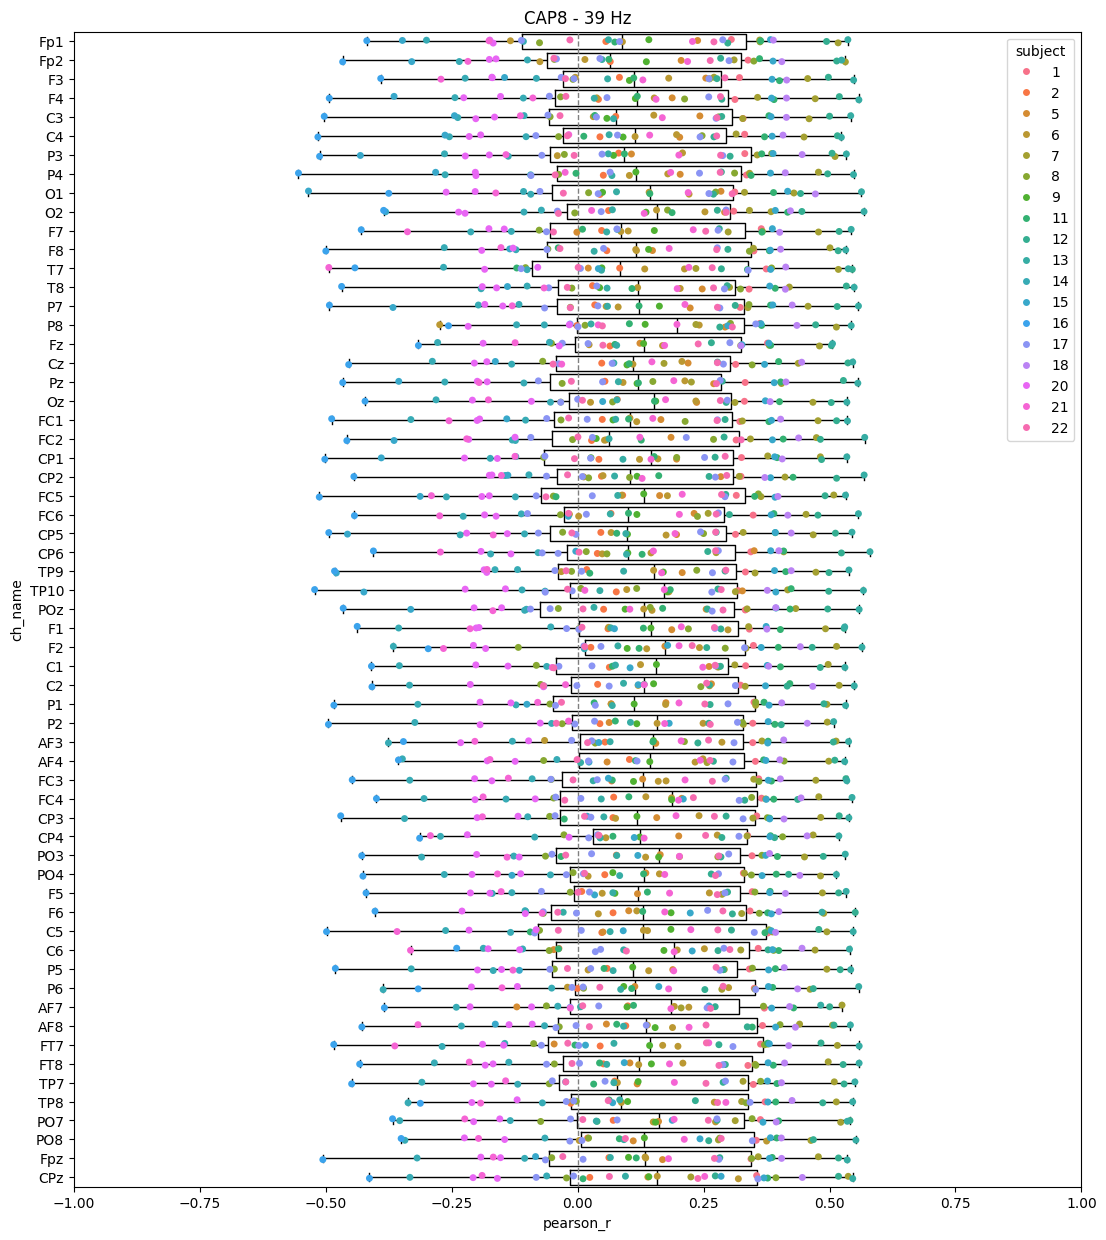

In [5]:
from matplotlib.animation import FuncAnimation
def animate(n):
    frequency, cap = df_freq_cap.iloc[n]
    selection = df[(df['ts_CAPS'] == cap) & (df['frequency_Hz'] == frequency)]
    plt.cla()
    sns.boxplot(data = selection, 
            x = 'pearson_r',
            y = 'ch_name',
            fill = False,
            color = 'black', 
            orient='h',
            whis=(0,100),
            linewidth = 1,
            ax = ax,
            )
    sns.stripplot(data = selection,
            x = 'pearson_r', 
            y = 'ch_name', 
            hue = 'subject', 
            orient='h',
            ax = ax,
            )
    plt.gca().get_legend().set_loc('upper right')
    plt.xlim(-1,1)
    plt.title(f'{cap} - {frequency} Hz')
    plt.axvline(0, color = 'grey', linewidth = 1, linestyle = '--')


fig, ax = plt.subplots(figsize = (13,15))
ani = FuncAnimation(fig, animate, interval=100, frames = len(df_freq_cap))
ani.save(f'animation_boxplot_custom_bands_{task}.mp4', writer='ffmpeg')
plt.show()

In [23]:
selection = df.groupby(['subject','ts_CAPS','anatomy','ch_name', 'frequency_Hz']).mean('pearson_r')

In [24]:
selection.reset_index(inplace = True)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39])

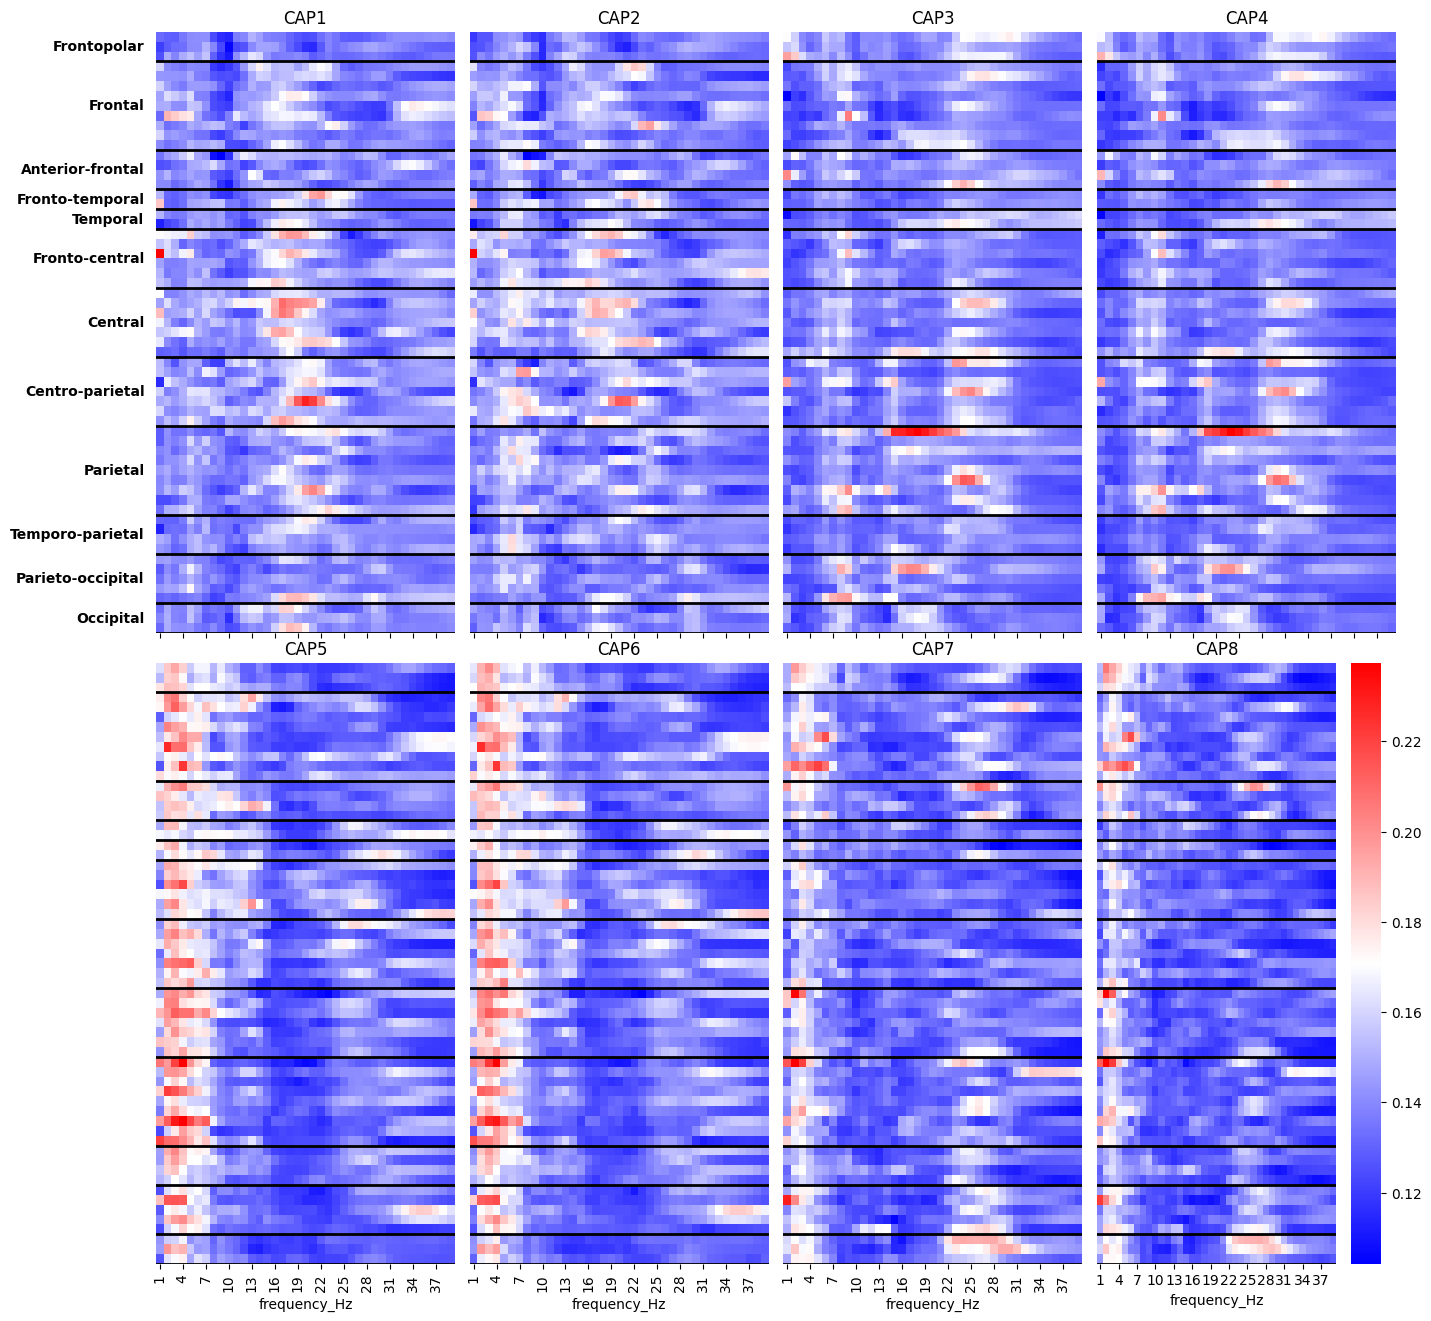

In [77]:
import matplotlib.gridspec as gridspec
caps = [c for c in range(1,9)]

#gs = gridspec.GridSpec(2, 4, figure=figure, wspace=0.05, hspace=0.05)  # Adjust wspace & hspace
figure, axes = plt.subplots(2,4, figsize = (16,16), sharex=True, 
                            sharey=True,
                            gridspec_kw= dict(wspace = 0.05, hspace = 0.05))


# Plot subplots
#axes = [figure.add_subplot(gs[i]) for i in range(8)]
for cap, ax in zip(caps, axes.flatten()):
   unique_select = selection.loc[selection['ts_CAPS'] == f'CAP{cap}']
   if cap == 1:
      plot_anatomy = True
      colorbar = False
   elif cap == 8:
      plot_anatomy = False
      colorbar = True
   else:
      plot_anatomy = False
      colorbar = False
   
   if cap < 5:
      x_labels = False
   else:
      x_labels = True
   plot_heatmap(unique_select, f"CAP{cap}", ax, colorbar=colorbar, plot_anat=plot_anatomy, x_labels=x_labels)
    #plt.tight_layout()



In [42]:
axes.shape

(2, 4)

In [79]:
import mne
montage = mne.channels.make_standard_montage('easycap-M1')

In [103]:
montage.ch

{'ch_pos': OrderedDict([('Fp1',
               array([-0.02933873,  0.09029533, -0.00331545])),
              ('Fp2', array([ 0.02933873,  0.09029533, -0.00331545])),
              ('F3', array([-0.05177571,  0.06393767,  0.0475    ])),
              ('F4', array([0.05177571, 0.06393767, 0.0475    ])),
              ('C3', array([-0.06833728, -0.        ,  0.06599255])),
              ('C4', array([0.06833728, 0.        , 0.06599255])),
              ('P3', array([-0.05177571, -0.06393767,  0.0475    ])),
              ('P4', array([ 0.05177571, -0.06393767,  0.0475    ])),
              ('O1', array([-0.02933873, -0.09029533, -0.00331545])),
              ('O2', array([ 0.02933873, -0.09029533, -0.00331545])),
              ('F7', array([-0.0768098 ,  0.05580558, -0.00331545])),
              ('F8', array([ 0.0768098 ,  0.05580558, -0.00331545])),
              ('T7', array([-0.09494213, -0.        , -0.00331545])),
              ('T8', array([ 0.09494213,  0.        , -0.00331545])),

In [106]:
montage.dig[3]

<DigPoint |     EEG #1 : (-29.3, 90.3, -3.3) mm    : unknown frame>

In [109]:
coordinates_mm = {}
for i, elec in enumerate(montage.dig[3:]):
    coordinates_mm[montage.ch_names[i]] = elec['r']

In [110]:
coordinates_mm

{'Fp1': array([-0.02933873,  0.09029533, -0.00331545]),
 'Fp2': array([ 0.02933873,  0.09029533, -0.00331545]),
 'F3': array([-0.05177571,  0.06393767,  0.0475    ]),
 'F4': array([0.05177571, 0.06393767, 0.0475    ]),
 'C3': array([-0.06833728, -0.        ,  0.06599255]),
 'C4': array([0.06833728, 0.        , 0.06599255]),
 'P3': array([-0.05177571, -0.06393767,  0.0475    ]),
 'P4': array([ 0.05177571, -0.06393767,  0.0475    ]),
 'O1': array([-0.02933873, -0.09029533, -0.00331545]),
 'O2': array([ 0.02933873, -0.09029533, -0.00331545]),
 'F7': array([-0.0768098 ,  0.05580558, -0.00331545]),
 'F8': array([ 0.0768098 ,  0.05580558, -0.00331545]),
 'T7': array([-0.09494213, -0.        , -0.00331545]),
 'T8': array([ 0.09494213,  0.        , -0.00331545]),
 'P7': array([-0.0768098 , -0.05580558, -0.00331545]),
 'P8': array([ 0.0768098 , -0.05580558, -0.00331545]),
 'Fz': array([4.18445162e-18, 6.83372810e-02, 6.59925452e-02]),
 'Cz': array([0.   , 0.   , 0.095]),
 'Pz': array([ 4.184451

# Average across electrode (y = subjects, x = frequency)

# Average across frequency (y = electrodes, x = subject)

In [7]:
cap_df

Empty DataFrame
Columns: [pearson_r, frequency_Hz, electrode, anatomy, ch_name]
Index: []

In [14]:
sorted_anatomy.groupby('anatomy').groups

{'anterior-frontal': ['AF8', 'AF3', 'AF4', 'AF7'], 'central': ['C3', 'C5', 'C6', 'C2', 'C4', 'Cz', 'C1'], 'centro-parietal': ['CP1', 'CP2', 'CP5', 'CP6', 'CP3', 'CP4', 'CPz'], 'frontal': ['F3', 'F6', 'F5', 'F2', 'Fz', 'F8', 'F7', 'F1', 'F4'], 'fronto-central': ['FC3', 'FC4', 'FC6', 'FC1', 'FC2', 'FC5'], 'fronto-temporal': ['FT7', 'FT8'], 'frontopolar': ['Fp1', 'Fpz', 'Fp2'], 'occipital': ['O2', 'Oz', 'O1'], 'parietal': ['P1', 'P3', 'Pz', 'P4', 'P8', 'P7', 'P5', 'P6', 'P2'], 'parieto-occipital': ['PO7', 'POz', 'PO3', 'PO8', 'PO4'], 'temporal': ['T7', 'T8'], 'temporo-parietal': ['TP7', 'TP8', 'TP10', 'TP9']}

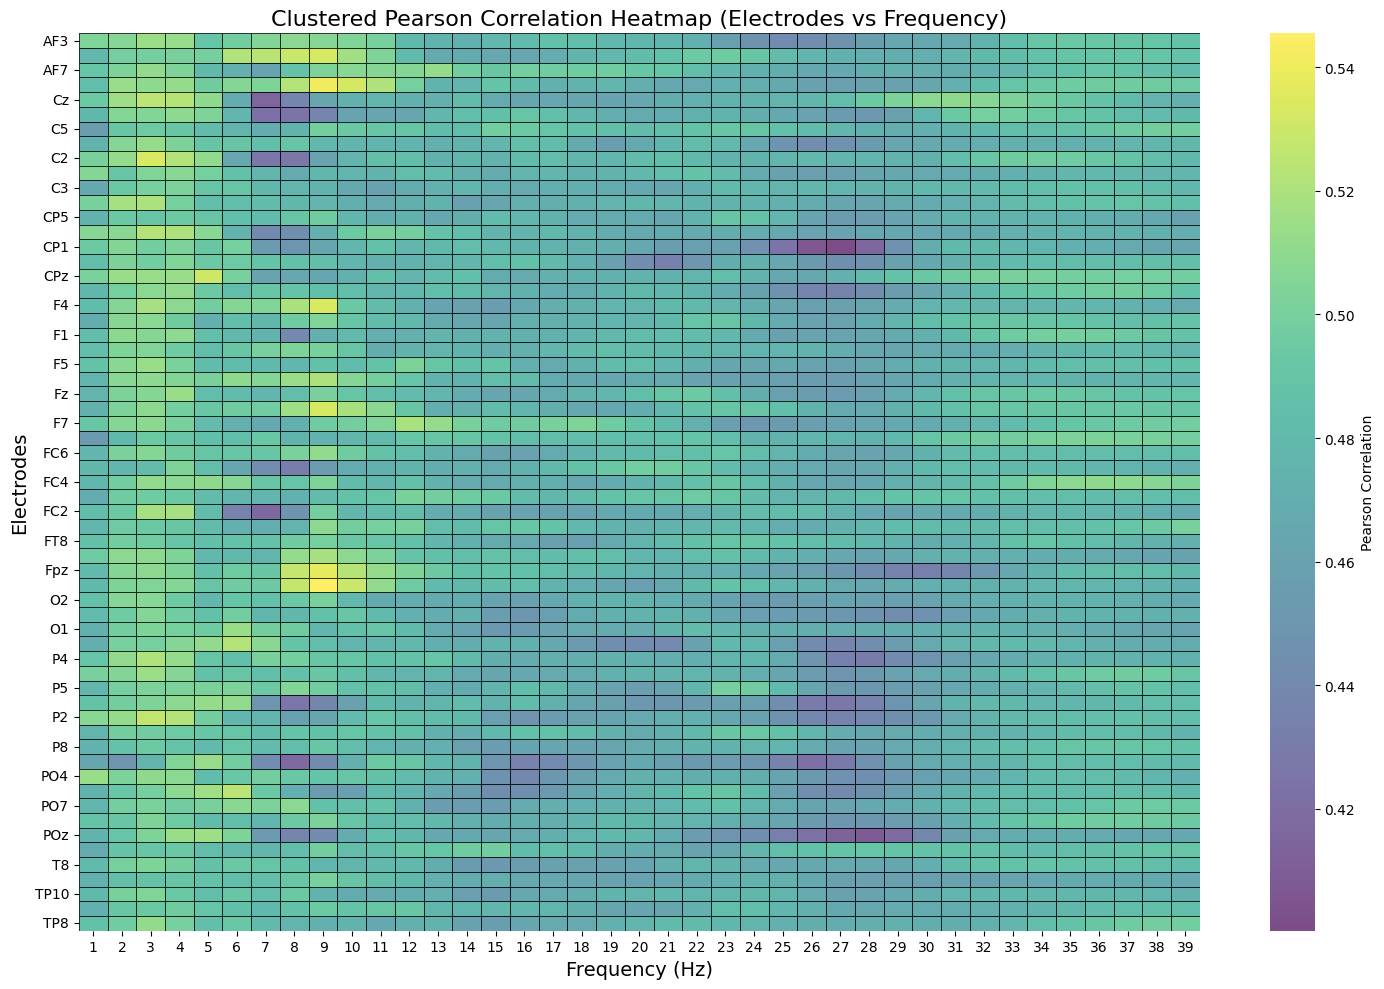

In [6]:
import numpy as np
from scipy.stats import ttest_1samp
from sklearn.utils import resample

heatmap_array = heatmap_data.fillna(0).values

# Define clustering parameters
n_permutations = 1000
cluster_threshold = 0.5

# Compute the observed t-statistics (test against 0 correlation as null hypothesis)
t_obs, p_values = ttest_1samp(heatmap_array, popmean=0, axis=1)

# Permutation testing to generate a null distribution
t_perm_max = []
t_perm_max = []
for _ in range(n_permutations):
    # Shuffle the data along the frequency dimension for each electrode
    permuted_data = np.apply_along_axis(np.random.permutation, axis=1, arr=heatmap_array)
    t_perm, _ = ttest_1samp(permuted_data, popmean=0, axis=1)
    t_perm_max.append(np.max(np.abs(t_perm)))

# Determine the critical value from the null distribution
t_critical = np.percentile(t_perm_max, 100 * (1 - cluster_threshold))

# Identify significant clusters (where |t_obs| > t_critical)
significant_clusters = np.abs(t_obs) > t_critical

# Create a mask for significant clusters
cluster_mask = np.zeros_like(heatmap_array, dtype=bool)
cluster_mask[significant_clusters, :] = True

# Plot the heatmap with significant clusters highlighted
plt.figure(figsize=(15, 10))
ax = sns.heatmap(
    heatmap_data,
    cmap='viridis',
    cbar_kws={'label': 'Pearson Correlation'},
    annot=False,
    linewidths=0.5,
    linecolor='black',
    alpha=0.7
)

# Overlay contours for significant clusters
ax.contour(cluster_mask, colors='white', linewidths=1.5, levels=[0.5])

# Adjust labels and title
ax.set_title('Clustered Pearson Correlation Heatmap (Electrodes vs Frequency)', fontsize=16)
ax.set_xlabel('Frequency (Hz)', fontsize=14)
ax.set_ylabel('Electrodes', fontsize=14)
plt.tight_layout()
plt.show()

<Axes: xlabel='frequency_Hz', ylabel='electrode'>

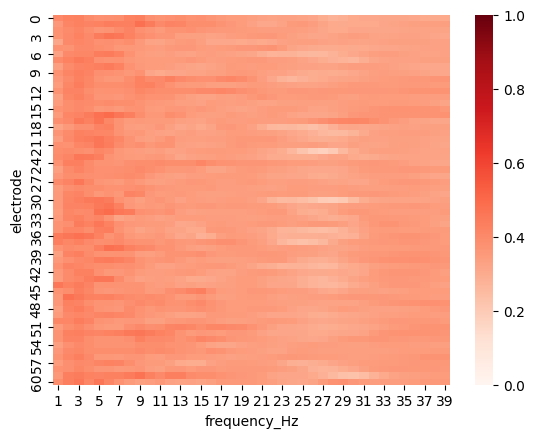

In [22]:
sns.heatmap(pivoted, vmin=0, vmax=1, cmap='Reds')

In [8]:
import pandas as pd
df_pupil = pd.read_csv('/home/slouviot/01_projects/eeg_brain_state_prediction/data/prediction_pupil_only.csv')
df_pupil['features'] = 'pupil dilation'
df_all = pd.read_csv('/home/slouviot/01_projects/eeg_brain_state_prediction/data/prediction_pupil_and_gfp.csv')
df_all['features'] = 'pupil dilation and gfp'
merged = pd.concat([df_pupil, df_all], axis = 0)

In [37]:
merged

Unnamed: 0  iteration subject session     run          task ts_CAPS  \
0             0          0  sub-01  ses-01  run-01  task-checker  tsCAP1   
1             1          0  sub-01  ses-01  run-01  task-checker  tsCAP2   
2             2          0  sub-01  ses-01  run-01  task-checker  tsCAP3   
3             3          0  sub-01  ses-01  run-01  task-checker  tsCAP4   
4             4          0  sub-01  ses-01  run-01  task-checker  tsCAP5   
..          ...        ...     ...     ...     ...           ...     ...   
443         443          0  sub-04  ses-02  run-01     task-rest  tsCAP6   
444         444          0  sub-04  ses-01  run-01     task-rest  tsCAP7   
445         445          0  sub-04  ses-02  run-01     task-rest  tsCAP7   
446         446          0  sub-04  ses-01  run-01     task-rest  tsCAP8   
447         447          0  sub-04  ses-02  run-01     task-rest  tsCAP8   

     pearson_r                                       eye_features  \
0     0.646971  ['pupil_dilation', 'first_derivative', 'second...   
1     0.622542  ['pupil_dilation', 'first_derivative', 'second...   
2     0.435859  ['pupil_dilation', 'first_derivative', 'second...   
3     0.398693  ['pupil_dilation', 'first_derivative', 'second...   
4     0.461929  ['pupil_dilation', 'first_derivative', 'second...   
..         ...                                                ...   
443   0.281929  ['pupil_dilation', 'first_derivative', 'second...   
444   0.054942  ['pupil_dilation', 'first_derivative', 'second...   
445   0.252124  ['pupil_dilation', 'first_derivative', 'second...   
446   0.062994  ['pupil_dilation', 'first_derivative', 'second...   
447   0.253926  ['pupil_dilation', 'first_derivative', 'second...   

     eeg_features_channel  eeg_features_band                features  
0                     NaN                NaN          pupil dilation  
1                     NaN                NaN          pupil dilation  
2                     NaN                NaN          pupil dilation  
3                     NaN                NaN          pupil dilation  
4                     NaN                NaN          pupil dilation  
..                    ...                ...                     ...  
443                   NaN                NaN  pupil dilation and gfp  
444                   NaN                NaN  pupil dilation and gfp  
445                   NaN                NaN  pupil dilation and gfp  
446                   NaN                NaN  pupil dilation and gfp  
447                   NaN                NaN  pupil dilation and gfp  

[904 rows x 12 columns]

(<Figure size 600x300 with 1 Axes>, <Axes: ylabel='Correlation(yhat,ytest)'>)

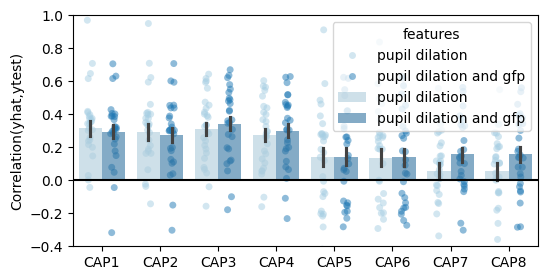

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_corr(df_pearson_r):
    df_pearson_r = df_pearson_r.sort_values(by = ['subject', 'ts_CAPS']).reset_index()        
    fig, ax = plt.subplots(figsize=(6,3))
    sns.stripplot(data = df_pearson_r,
                x = 'ts_CAPS',
                y = 'pearson_r',
                hue = 'features',
                ax = ax,
                palette = 'Paired',
                alpha=0.5, 
                size=5, 
                zorder=0,
                dodge = True,
                )

    sns.barplot(data = df_pearson_r, 
                x = 'ts_CAPS', 
                y = 'pearson_r', 
                errorbar = ('ci',68),
                ax = ax, 
                palette = 'Paired',
                alpha=0.6, 
                width=0.8, 
                zorder=1,
                hue = 'features'
                )

    caps_names = ['CAP1','CAP2','CAP3','CAP4','CAP5','CAP6','CAP7','CAP8']
    plt.ylim(-0.4,1)
    plt.xlabel('')
    plt.ylabel('Correlation(yhat,ytest)')#, size = 12)
    plt.xticks(ticks = np.arange(8), labels = caps_names)#, size = 12)
    plt.axhline(0, 
                linewidth = 1.5,
                color = 'black')
    
    #plt.axhline(0.5, 
    #            linestyle = '--',
    #            linewidth = 1,
    #            color = "black",
    #            alpha = 0.5)
    
    return fig, ax
merged_checker = merged[merged['task'] == 'task-checker']
plot_corr(merged_checker)

In [12]:
merged_checker.to_csv('/home/slouviot/01_projects/eeg_brain_state_prediction/data/merged_pupil_gfp_checker.csv')

/tmp/ipykernel_2365374/2626263796.py:71: UserWarning: You passed a edgecolor/edgecolors ((0.6509803921568628, 0.807843137254902, 0.8901960784313725)) for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(
/tmp/ipykernel_2365374/2626263796.py:71: UserWarning: You passed a edgecolor/edgecolors ((0.12156862745098039, 0.47058823529411764, 0.7058823529411765)) for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(
/tmp/ipykernel_2365374/2626263796.py:71: UserWarning: You passed a edgecolor/edgecolors ((0.6980392156862745, 0.8745098039215686, 0.5411764705882353)) for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(
/tmp/ipykernel_2365374/2626263796.py:71: UserWarning: You passed a edgecolor/edgecolors ((0.2, 0

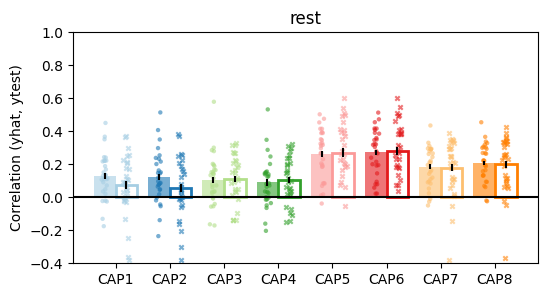

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

merged_checker = merged[merged['task'] == 'task-rest']
def plot_corr_with_jitter(df_pearson_r):
    df_pearson_r = df_pearson_r.sort_values(by=['subject', 'ts_CAPS']).reset_index()
    fig, ax = plt.subplots(figsize=(6, 3))

    caps_names = ['CAP1', 'CAP2', 'CAP3', 'CAP4', 'CAP5', 'CAP6', 'CAP7', 'CAP8']
    unique_features = df_pearson_r['features'].unique()
    if len(unique_features) != 2:
        raise ValueError("The function expects exactly two unique features.")

    # Assign CAP colors
    cap_colors = sns.color_palette('Paired', len(caps_names))

    # Bar width adjustment
    bar_width = 0.4
    offsets = [-bar_width / 2, bar_width / 2]

    # Marker styles for the features
    feature_markers = {'pupil dilation': 'o', 'pupil dilation and gfp': 'x'}

    for i, feature in enumerate(unique_features):
        feature_data = df_pearson_r[df_pearson_r['features'] == feature]
        for j, cap in enumerate(caps_names):
            cap_data = feature_data[feature_data['ts_CAPS'] == f'tsCAP{j+1}']
            
            if feature == 'pupil dilation':
                kwargs = {"edgecolors": "none"}
            else:
                kwargs = {"edgecolors": cap_colors[j]}

            if not cap_data.empty:
                # X positions
                x_position = j + offsets[i]

                # Compute confidence interval for error bars
                mean_value = cap_data['pearson_r'].mean()
                std_dev = cap_data['pearson_r'].std()
                ci_68 = std_dev / np.sqrt(len(cap_data)) * 0.68

                # Bar style: filled or outline
                if feature == 'pupil dilation':
                    # Filled bar with no edge color
                    ax.bar(
                        x_position,
                        mean_value,
                        yerr=ci_68,
                        width=bar_width,
                        color=cap_colors[j],
                        alpha=0.6,
                        label=feature if j == 0 else None
                    )
                else:
                    # Outlined bar with edge color
                    ax.bar(
                        x_position,
                        mean_value,
                        yerr=ci_68,
                        width=bar_width,
                        color='white',
                        edgecolor=cap_colors[j],
                        linewidth=2,
                        label=feature if j == 0 else None
                    )

                # Add scatter points with jitter for the stripplot
                jittered_positions = np.random.normal(x_position, 0.03, size=len(cap_data))
                ax.scatter(
                    jittered_positions,
                    cap_data['pearson_r'],
                    color=cap_colors[j],
                    alpha=0.6,
                    marker=feature_markers[feature],
                    s = 10,
                    label=None,
                    **kwargs,
                )

    plt.ylim(-0.4, 1)
    plt.xlabel('')
    plt.ylabel('Correlation (yhat, ytest)')
    plt.xticks(ticks=np.arange(len(caps_names)), labels=caps_names)
    plt.axhline(0, linewidth=1.5, color='black')
    #plt.legend(title="Features",bbox_to_anchor=(1, 1))
    plt.title("rest")

    return fig, ax

# Visualize the final output with jitter
fig, ax = plot_corr_with_jitter(merged_checker)
fig.savefig('/home/slouviot/01_projects/eeg_brain_state_prediction/figures/pupil_pupil_and_gfp_rest.png', bbox_inches='tight', dpi=300)
plt.show()

/home/slouviot/01_projects/eeg_brain_state_prediction/src/combine_data.py:1016: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(data = df_pearson_r,
/home/slouviot/01_projects/eeg_brain_state_prediction/src/combine_data.py:1026: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data = df_pearson_r,


(<Figure size 600x300 with 1 Axes>, <Axes: ylabel='Correlation(yhat,ytest)'>)

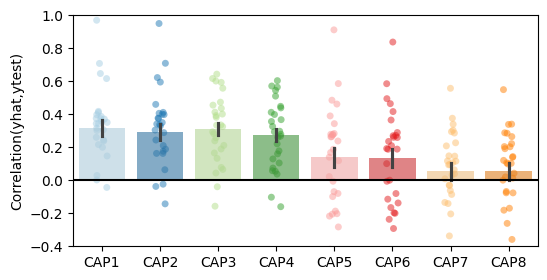

In [10]:
import src.combine_data as combine_data
combine_data.plot_corr(df_pupil[df_pupil['task'] == 'task-checker'])

In [ ]:
cap1.drop(columns=['Unnamed: 0'], inplace = True)


In [8]:
df_pupil

Unnamed: 0  iteration subject session     run          task ts_CAPS  \
0             0          0  sub-01  ses-01  run-01  task-checker  tsCAP1   
1             1          0  sub-01  ses-01  run-01  task-checker  tsCAP2   
2             2          0  sub-01  ses-01  run-01  task-checker  tsCAP3   
3             3          0  sub-01  ses-01  run-01  task-checker  tsCAP4   
4             4          0  sub-01  ses-01  run-01  task-checker  tsCAP5   
..          ...        ...     ...     ...     ...           ...     ...   
451         451          0  sub-04  ses-02  run-01     task-rest  tsCAP6   
452         452          0  sub-04  ses-01  run-01     task-rest  tsCAP7   
453         453          0  sub-04  ses-02  run-01     task-rest  tsCAP7   
454         454          0  sub-04  ses-01  run-01     task-rest  tsCAP8   
455         455          0  sub-04  ses-02  run-01     task-rest  tsCAP8   

     pearson_r                                       eye_features  \
0     0.646971  ['pupil_dilation', 'first_derivative', 'second...   
1     0.622542  ['pupil_dilation', 'first_derivative', 'second...   
2     0.435859  ['pupil_dilation', 'first_derivative', 'second...   
3     0.398693  ['pupil_dilation', 'first_derivative', 'second...   
4     0.461929  ['pupil_dilation', 'first_derivative', 'second...   
..         ...                                                ...   
451   0.200371  ['pupil_dilation', 'first_derivative', 'second...   
452   0.083113  ['pupil_dilation', 'first_derivative', 'second...   
453   0.163068  ['pupil_dilation', 'first_derivative', 'second...   
454   0.093225  ['pupil_dilation', 'first_derivative', 'second...   
455   0.157780  ['pupil_dilation', 'first_derivative', 'second...   

     eeg_features_channel  eeg_features_band        features  
0                     NaN                NaN  pupil dilation  
1                     NaN                NaN  pupil dilation  
2                     NaN                NaN  pupil dilation  
3                     NaN                NaN  pupil dilation  
4                     NaN                NaN  pupil dilation  
..                    ...                ...             ...  
451                   NaN                NaN  pupil dilation  
452                   NaN                NaN  pupil dilation  
453                   NaN                NaN  pupil dilation  
454                   NaN                NaN  pupil dilation  
455                   NaN                NaN  pupil dilation  

[456 rows x 12 columns]